# Análisis de NDVI con Imágenes de Sentinel 2 

In [115]:
#Configuration
from sentinelhub import SHConfig


INSTANCE_ID = '215c373a-4b94-4f9f-988b-054f995547df'

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

In [116]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [213]:
#Libraries
import datetime
import numpy as np
import pandas as pd
import json
import matplotlib
import os
from sentinelhub import CustomUrlParam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sentinelhub import WmsRequest, MimeType, CRS, Geometry

In [291]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)

## 1.- Extracción de la data

In [118]:
#import dates 
dates = pd.read_excel('SentinelHubImage-available_dates.xlsx')
dates.head()

,id,farm,_date,_datetime_utc,validated
0,8519,163,2016-07-15,2016-07-15 15:23:58,1
1,8518,163,2016-09-13,2016-09-13 15:26:48,1
2,8515,163,2016-11-22,2016-11-22 15:19:30,1
3,8514,163,2016-12-02,2016-12-02 15:21:03,1
4,8513,163,2016-12-22,2016-12-22 15:23:53,1


In [119]:
dates['_date']

0     2016-07-15
1     2016-09-13
2     2016-11-22
3     2016-12-02
4     2016-12-22
         ...    
84    2020-02-10
85    2020-02-15
86    2020-03-11
87    2020-04-15
88    2020-04-20
Name: _date, Length: 89, dtype: object

In [120]:
#Import Json
with open('farm_map.json') as file:
    lotes = json.load(file)     

In [121]:
#Number of features
lotes = lotes['features']
len(lotes)

33

In [122]:
var1= lotes[0]['geometry']

In [123]:
#exploring Json
for index in range(1):
    print(lotes[index]['geometry'])
    print(lotes[index]['properties']['unit']['name'])
    print(lotes[index]['properties']['unit']['id'])

{'type': 'Polygon', 'coordinates': [[[-75.6396578867764, -14.199701335951724], [-75.64231663022875, -14.20062882414364], [-75.64298408105815, -14.198802571721302], [-75.64032613621433, -14.197876401443217], [-75.6396578867764, -14.199701335951724]]]}
AGRICOLA CHAPI.DON ERNESTO.PAL-1.36
90214


In [132]:
#transform coordinates to bbox
betsiboka_bbox = Geometry(geometry = var1, crs=CRS.WGS84).bbox
print(betsiboka_bbox)

-75.64298408105815,-14.20062882414364,-75.6396578867764,-14.197876401443217


In [133]:
wms_bands_request = WmsRequest(
    layer='BANDS-S2-L1C',
    bbox=betsiboka_bbox,
    time='2016-07-15',
    width=512,
    image_format=MimeType.TIFF_d32f,
    config=config
)

wms_bands_img = wms_bands_request.get_data()

In [134]:
wms_bands_img[0][:, :, 12].shape

(437, 512)

In [156]:
#folder to save images
path = os.getcwd()+'/img'
os.mkdir(path)

In [173]:
my_evalscript = '''
var ndvi = (B08-B04)/(B08+B04); 
return [ndvi]; '''

In [178]:
#DataFrame with mean_ndvi by lot and date
data = pd.DataFrame(columns = ['id','date','name','mean_ndvi'])
data.head()

,id,date,name,mean_ndvi


In [179]:
## extract of the data
for index in range(len(lotes)):
    for date in dates['_date']:
        coordinates = lotes[index]['geometry']
        betsiboka_bbox = Geometry(geometry = coordinates, crs=CRS.WGS84).bbox
        

        wms_bands_request = WmsRequest(
        layer= 'BANDS-S2-L1C',
        bbox=betsiboka_bbox,
        time= date,
        width=512,
        custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript},
        image_format=MimeType.TIFF_d32f,
        config=config
        )

        wms_bands_img = wms_bands_request.get_data()

        image_ndvi = wms_bands_img[0]
        mean_ndvi = image_ndvi.mean()

        lot_id = lotes[index]['properties']['unit']['id']
        lot_name = lotes[index]['properties']['unit']['name']
        
        #filling data to DataFrame
        data = data.append([{'id': lot_id,'date': date ,'name': lot_name ,'mean_ndvi': mean_ndvi}],  ignore_index = True)
        
        
        matplotlib.image.imsave("img/{}_{}.png".format(lot_id,date), image_ndvi)

In [180]:
data.head()

,id,date,name,mean_ndvi
0,90214,2016-07-15,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.514680
1,90214,2016-09-13,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.450306
2,90214,2016-11-22,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.565036
3,90214,2016-12-02,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.520824
4,90214,2016-12-22,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.486083


In [181]:
data.shape

(2937, 4)

In [182]:
#save to csv
data.to_csv('date_lot_indv.csv',index = False, header = True)

## Análisis con la data extraída

In [187]:
desc = data['mean_ndvi'].describe()
desc

count    2937.000000
mean        0.387416
std         0.179033
min         0.038361
25%         0.208376
50%         0.460179
75%         0.548776
max         0.660646
Name: mean_ndvi, dtype: float64

Descripción general de los valores promedio de NDVI. En total se obtuvieron 2937 datos, lo cual equivales a los 33 lotes entregados en el Json, por los 89 fechas provistas para hacer el análiss

In [269]:
#Plots size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18.0, 7)
plt.rcParams['axes.facecolor'] = 'w'

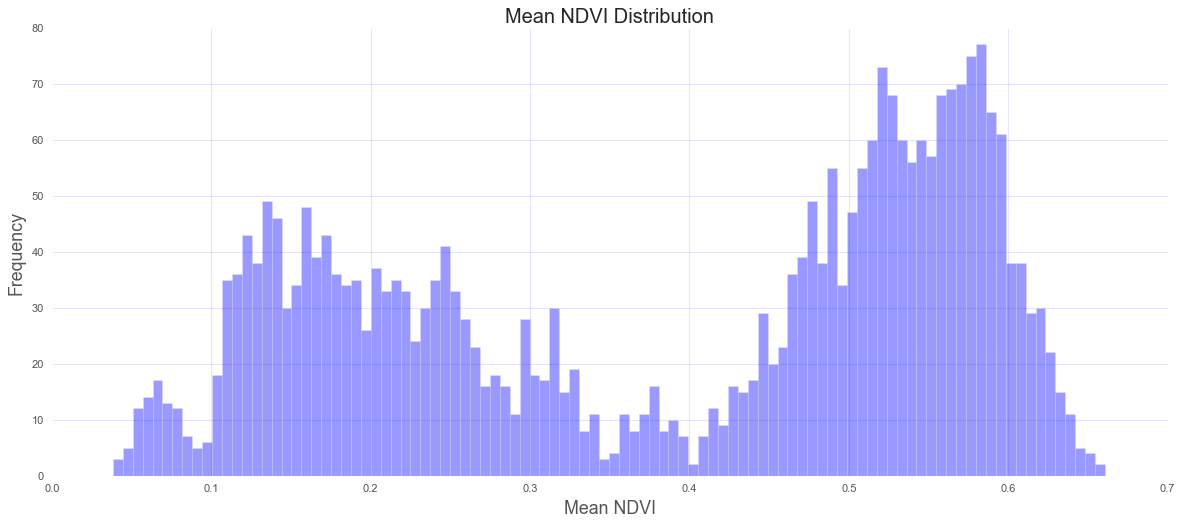

In [257]:
sns.distplot(data['mean_ndvi'], kde=False, color='blue', bins=100)
plt.title('Mean NDVI Distribution', fontsize=18)
plt.grid(color = 'b', alpha = 0.1)
plt.xlabel('Mean NDVI', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

Este primer histograma, muestra una posible separación de la data en dos grupos. Es probable encontrar más adelante lotes cuyo valor de NDVI promedio sea muy bajo, inferior a 0.2 por tratarse se zonas de baja vagetación o cuyos cultivos se hayan encontrado enfermos. Y por otro lado lotes con una clara muetra de valores altos en los cuales si hay muestra de vegetación.

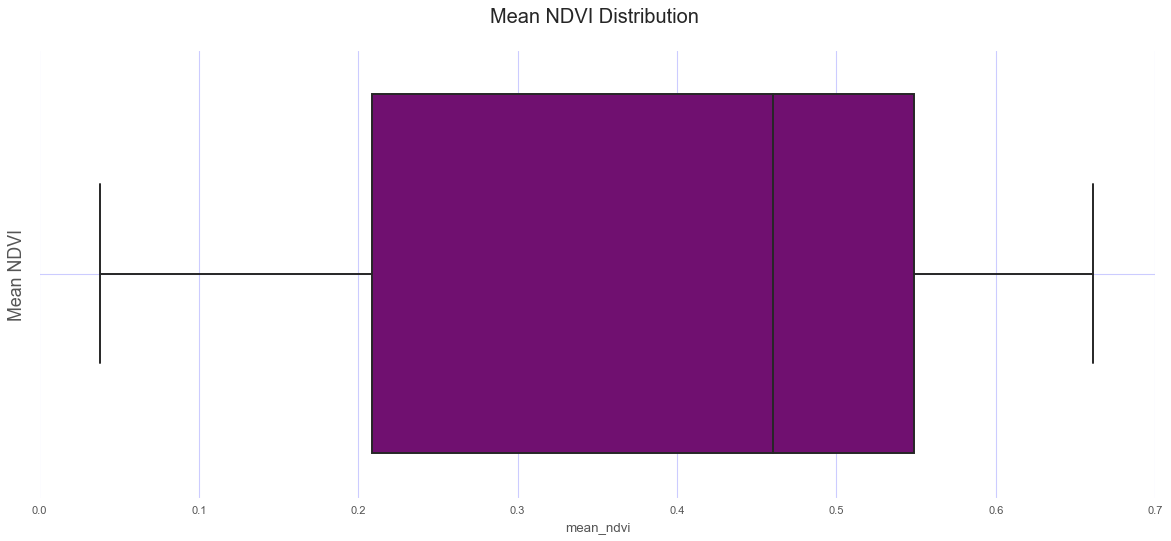

In [262]:
sns.boxplot(x="mean_ndvi", data=data, color = 'purple')
plt.grid(color = 'b', alpha = 0.2)
plt.title('Mean NDVI Distribution \n', fontsize=18)
plt.ylabel('Mean NDVI', fontsize=16)
plt.show()

El boxplot muestra concentración de valores de NDVI entre 0.2 y 0.55 aprox, teniendo una desviación hacia la derecha, es decir hay más valores altos de NDVI promedio, ya que el 50% de los valoresestá por sobre 0.46

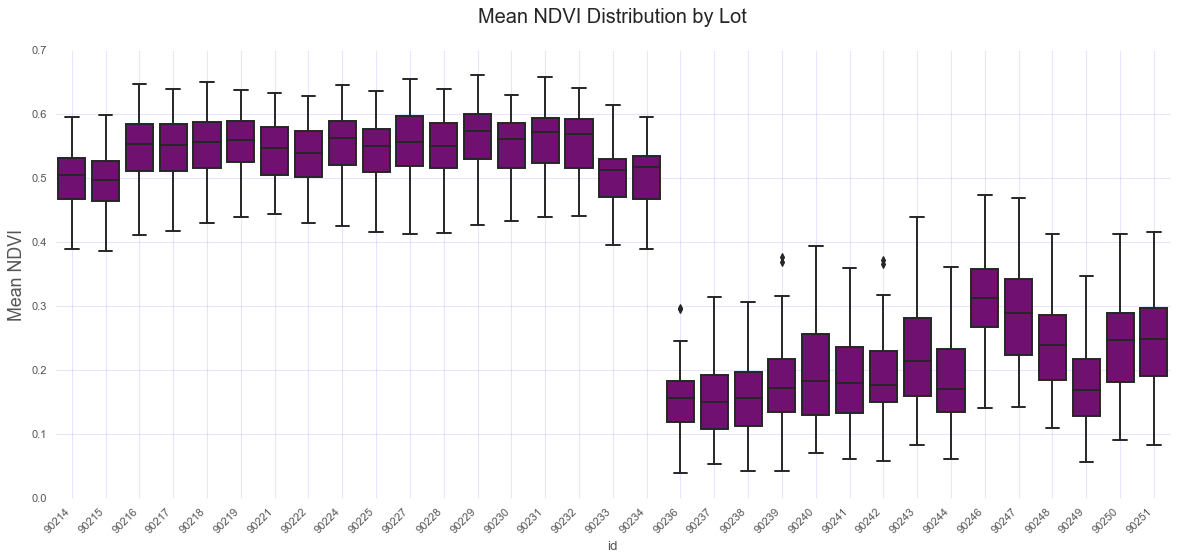

In [265]:
sns.boxplot(y="mean_ndvi",x = 'id', data=data, color = 'purple')
plt.grid(color = 'b', alpha = 0.1)
plt.title('Mean NDVI Distribution by Lot\n', fontsize=18)
plt.ylabel('Mean NDVI', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
plt.show()

Partiendo con el análisis por Lote, vemos la separación que mostraba también el histograma. Un primer grupo de lotes cultivados a lo largo del tiempo, y otro grupo de lotes sin cultivar, con pocos espacios cultivados o con problemas.

In [331]:
#transform date column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [285]:
plt.rcParams['figure.figsize'] = (18.0, 5)

In [273]:
ids = data['id'].unique()
ids

array([90214, 90215, 90216, 90217, 90218, 90219, 90221, 90222, 90224,
       90225, 90227, 90228, 90229, 90230, 90231, 90232, 90233, 90234,
       90250, 90251, 90246, 90247, 90248, 90236, 90237, 90238, 90239,
       90240, 90241, 90242, 90243, 90244, 90249], dtype=object)

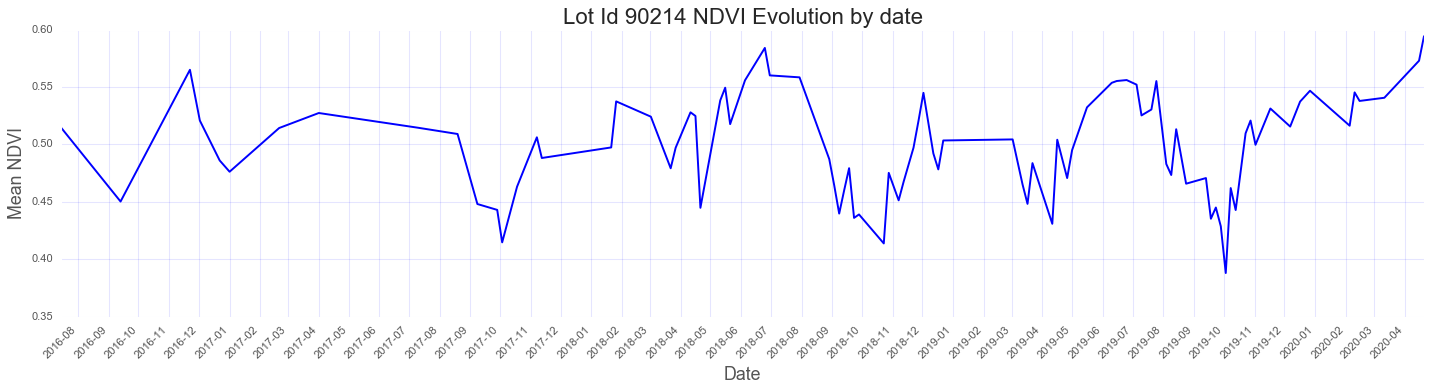

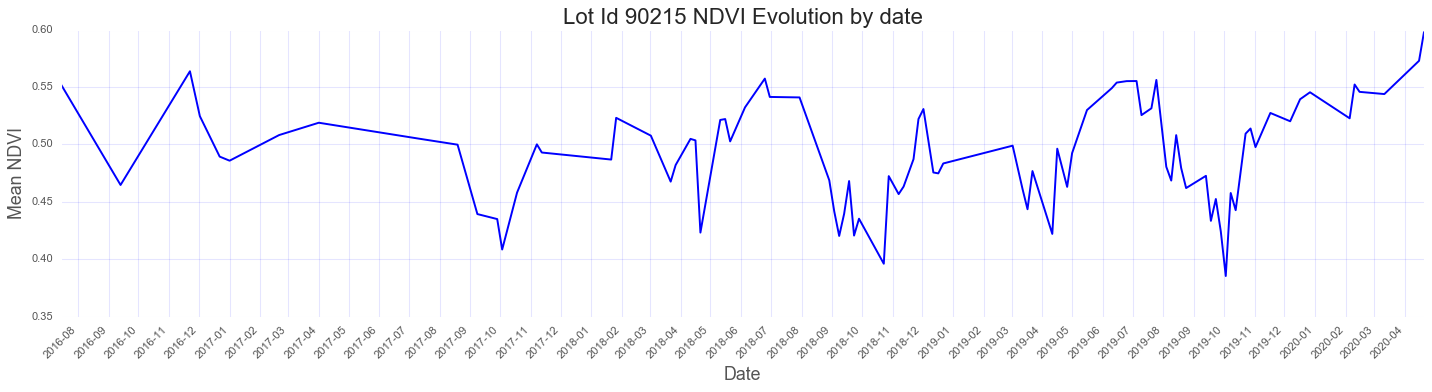

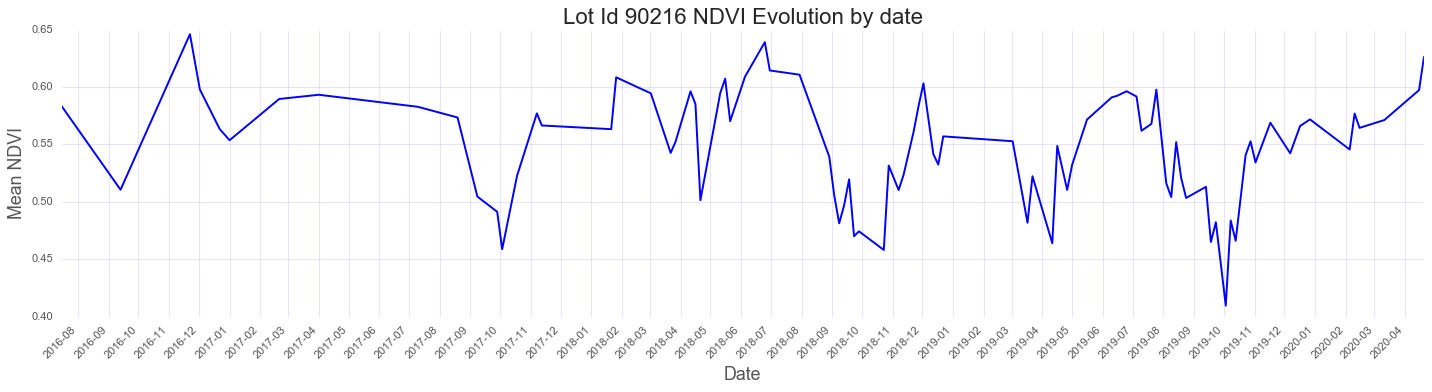

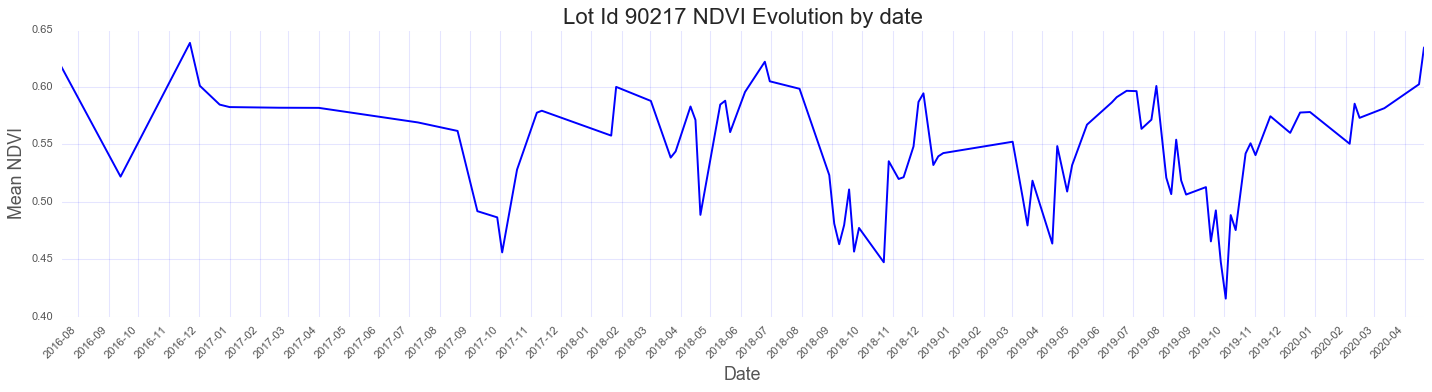

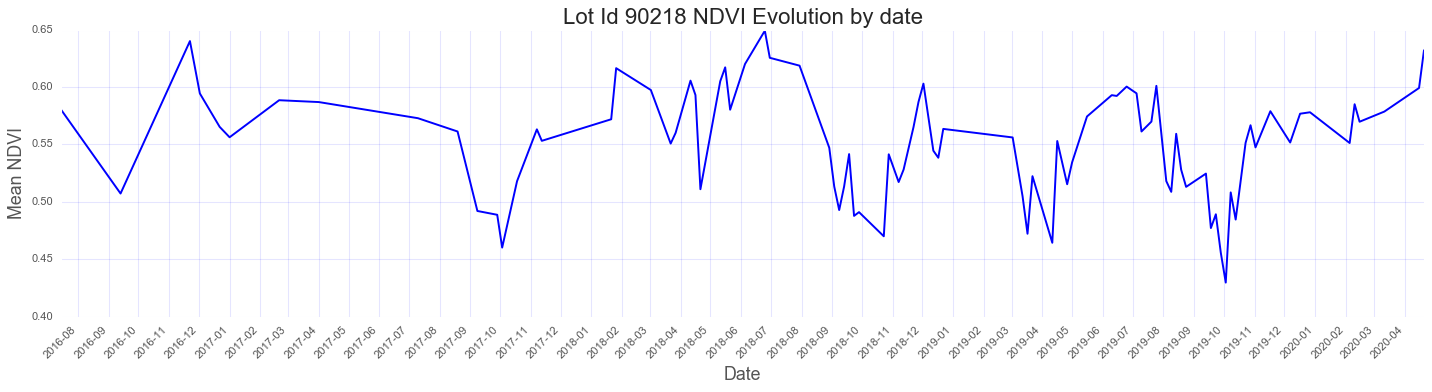

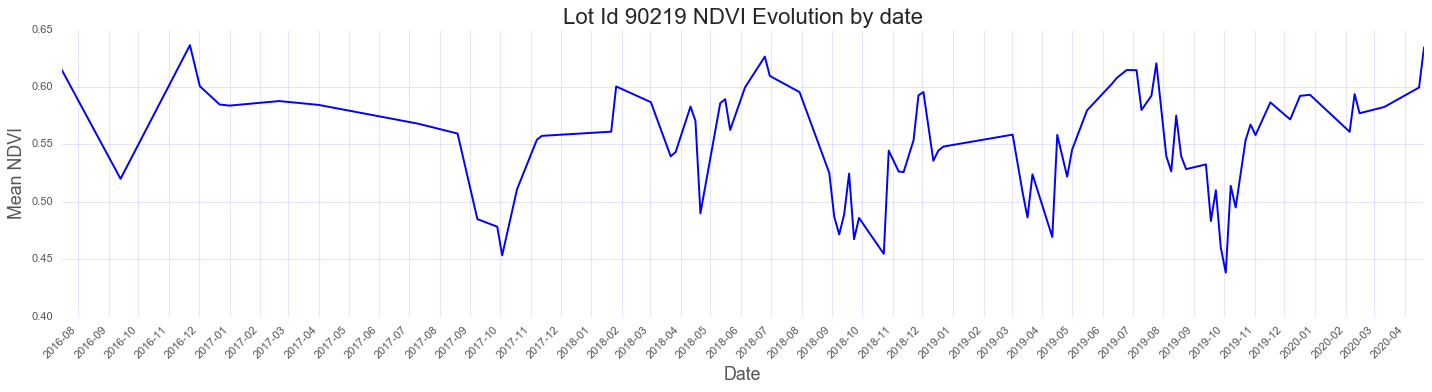

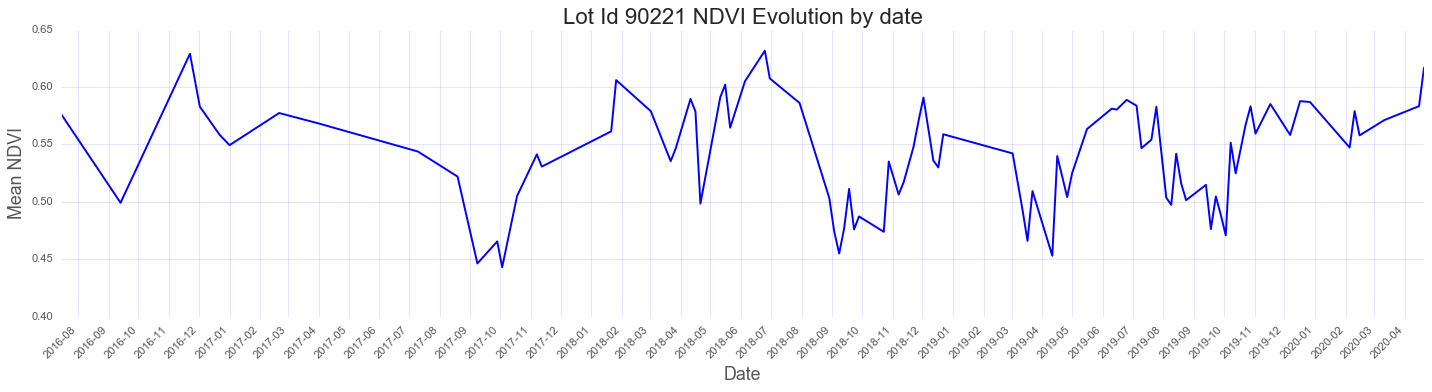

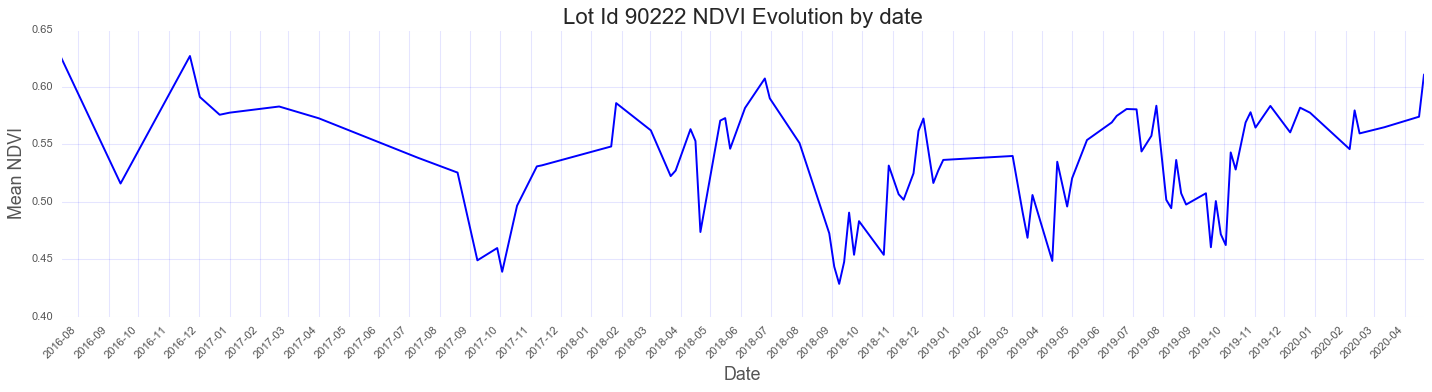

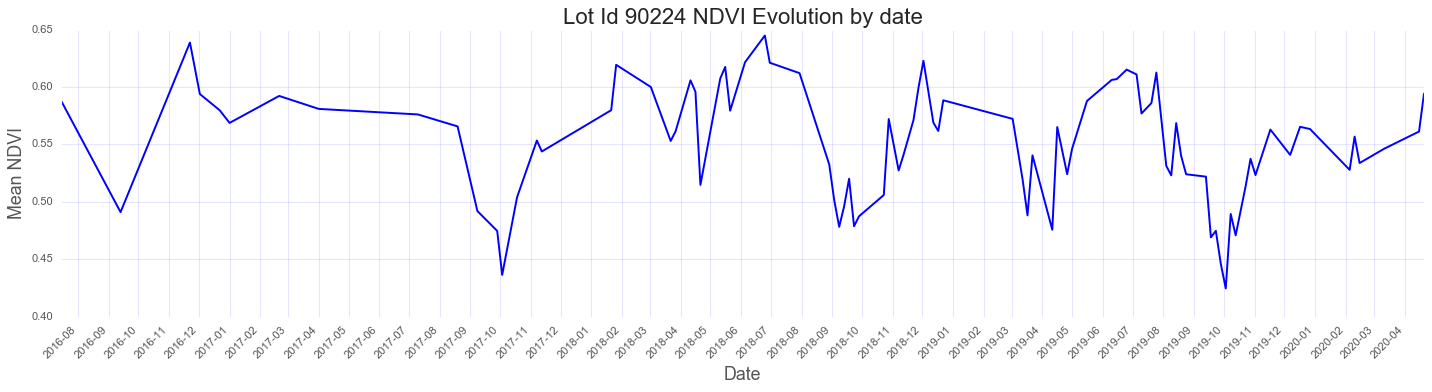

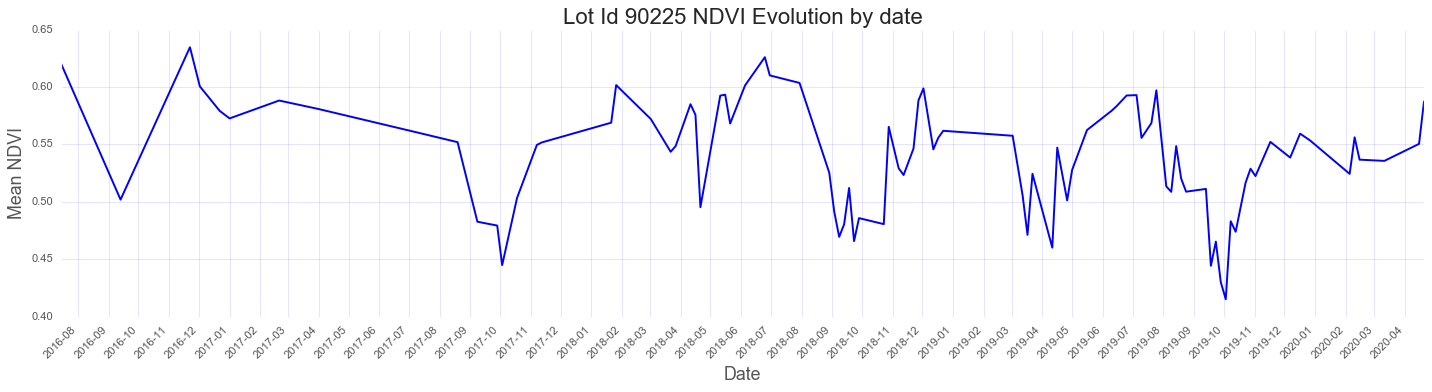

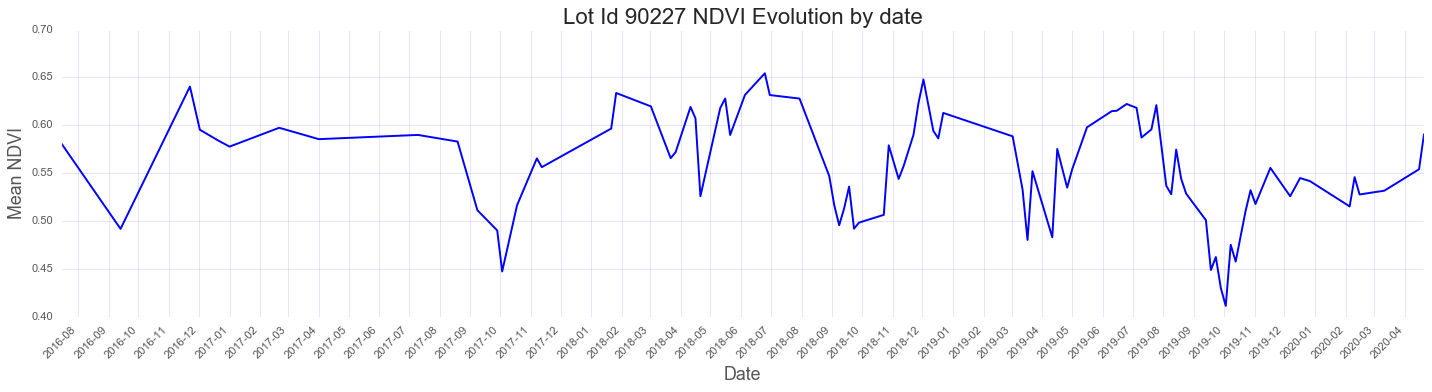

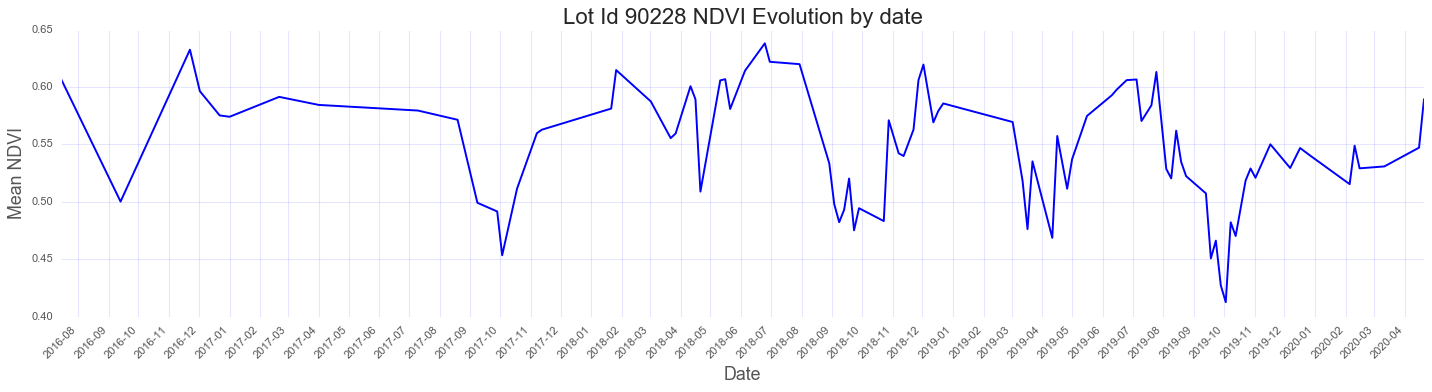

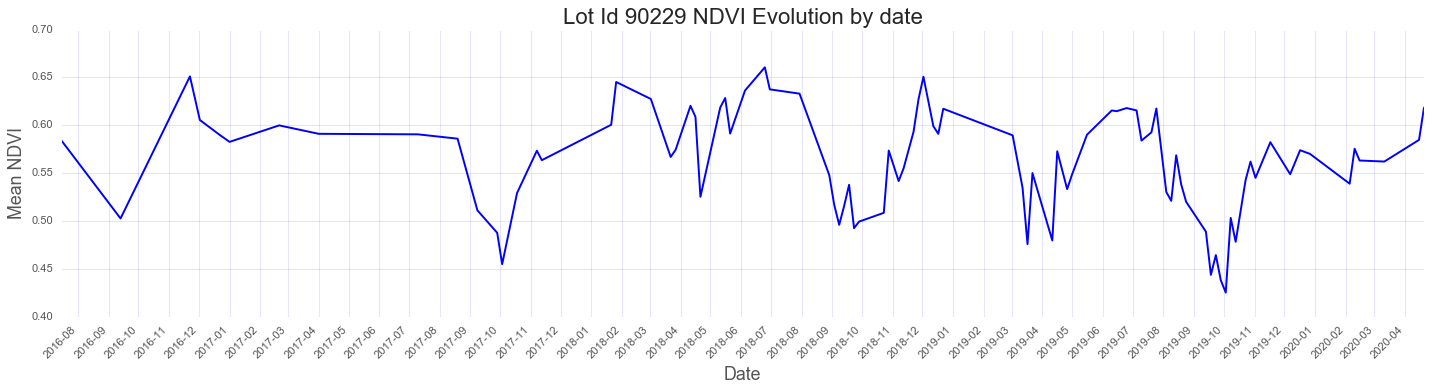

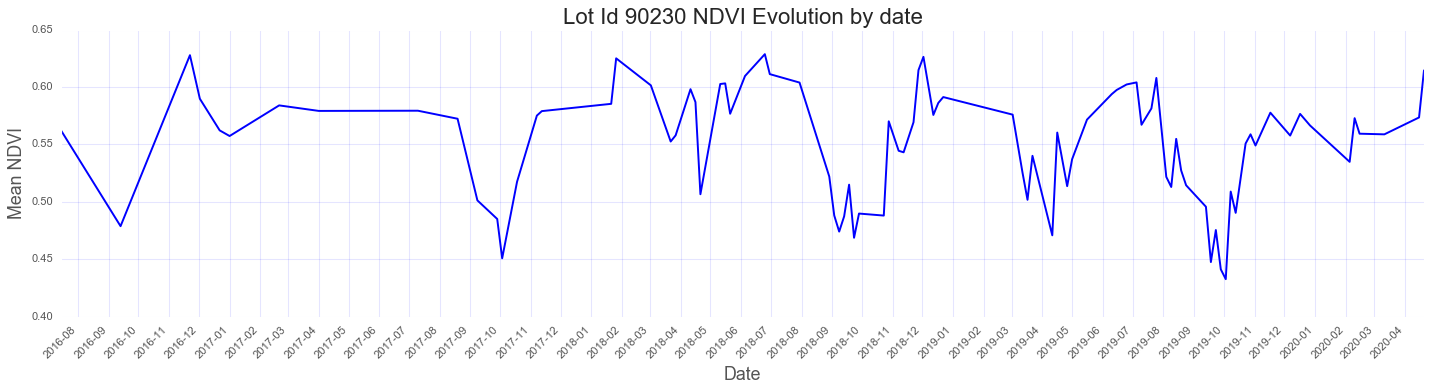

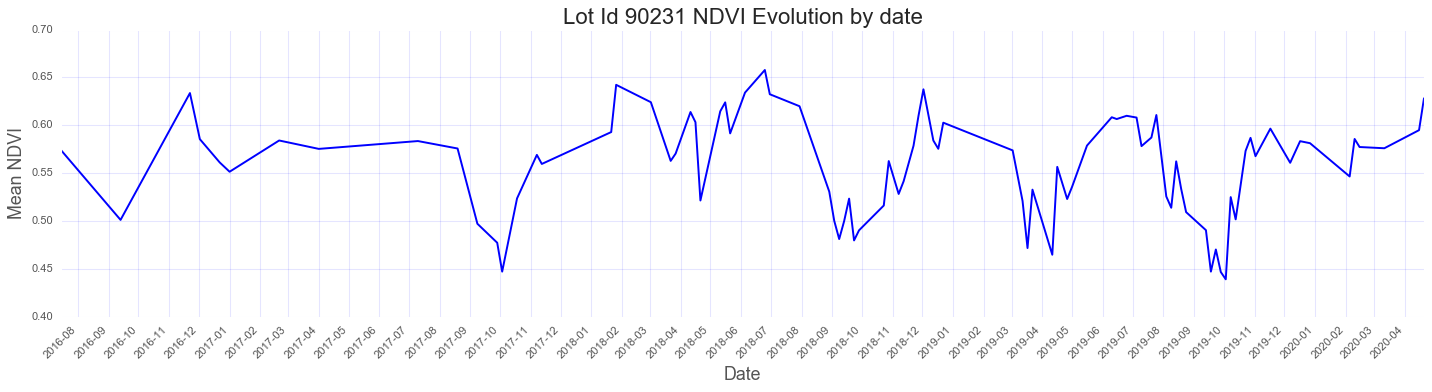

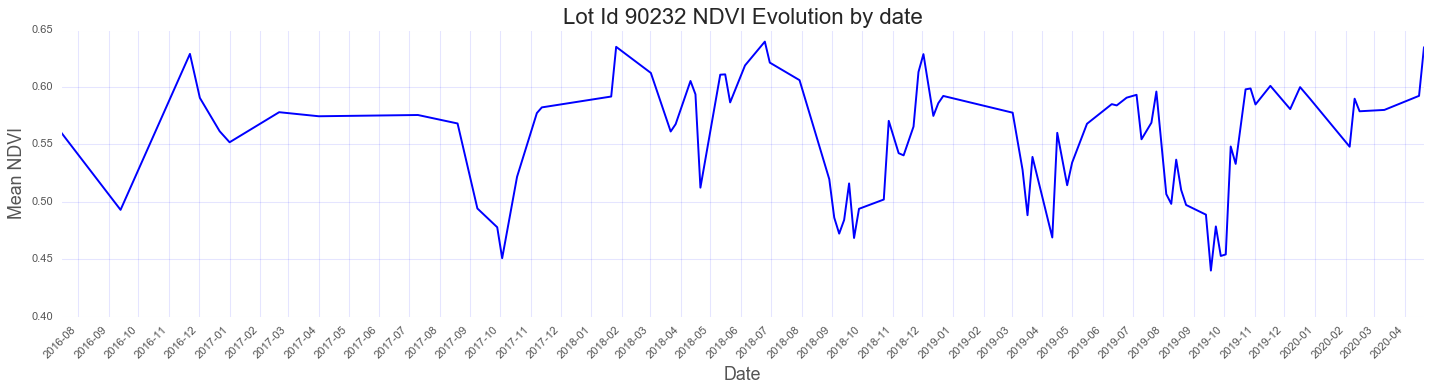

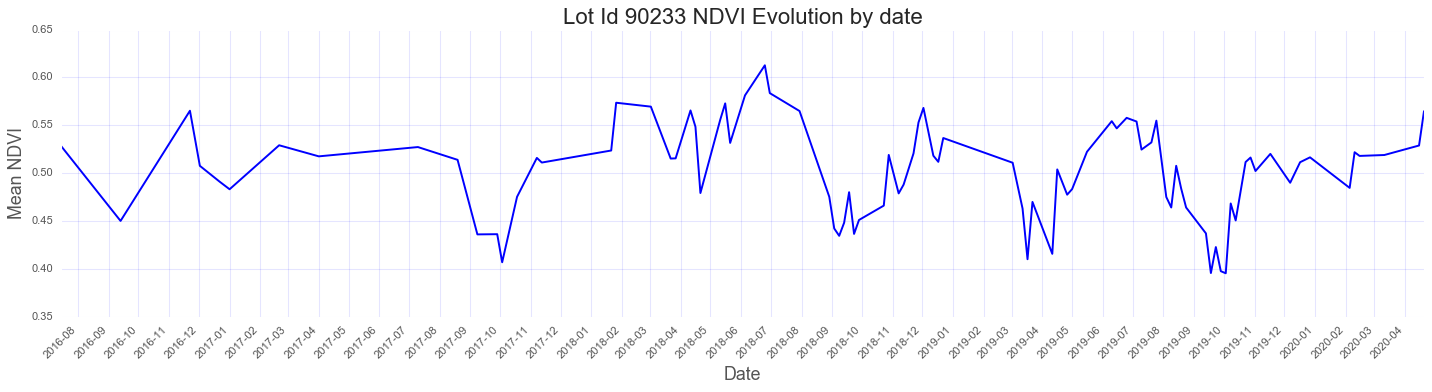

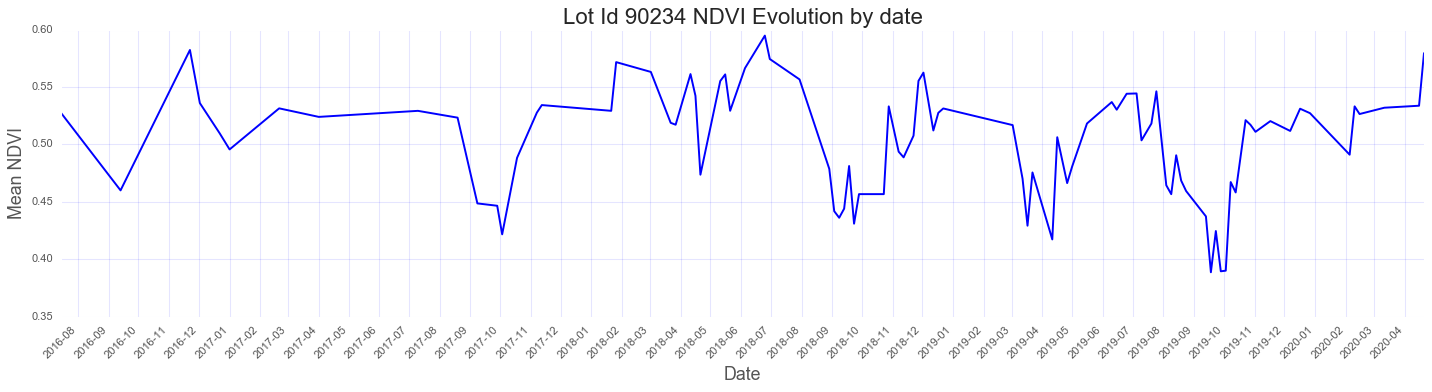

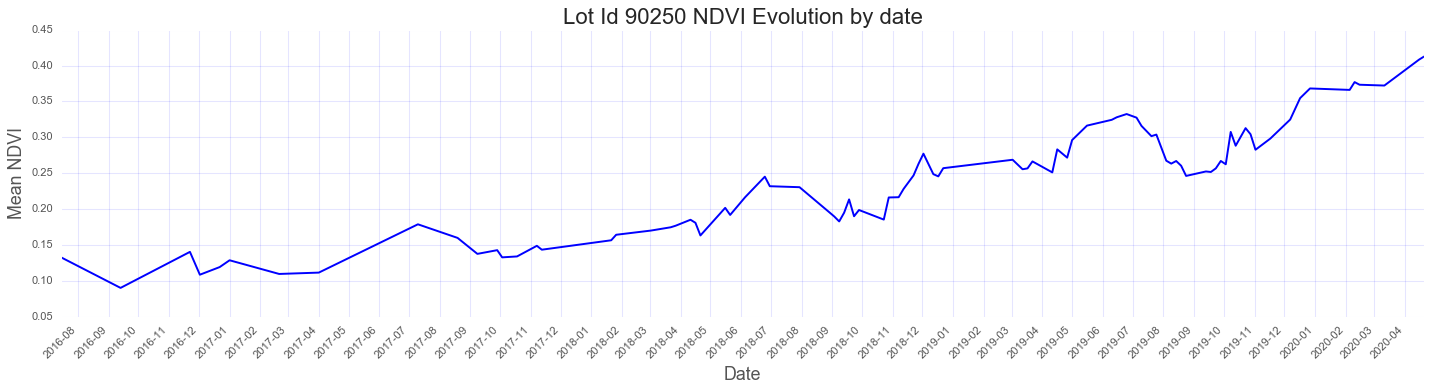

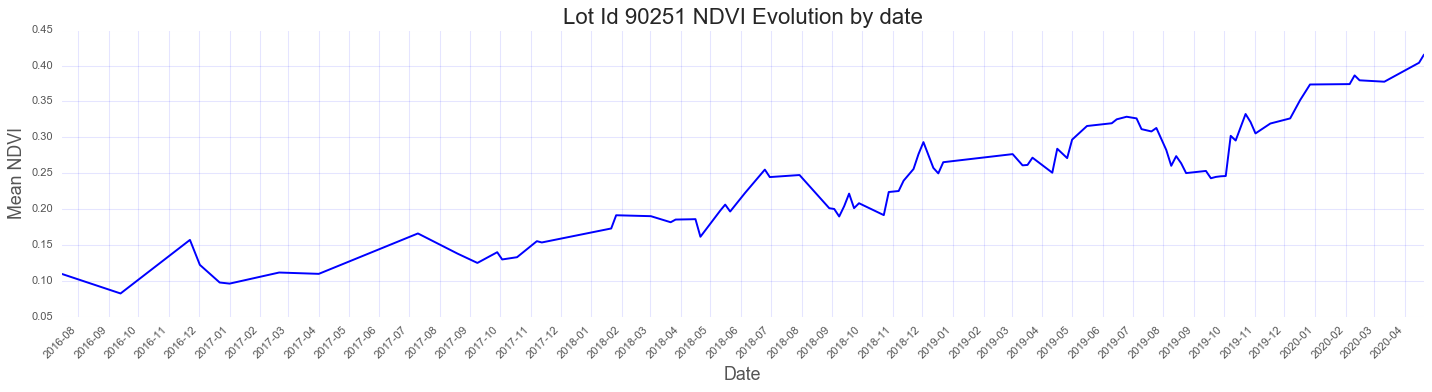

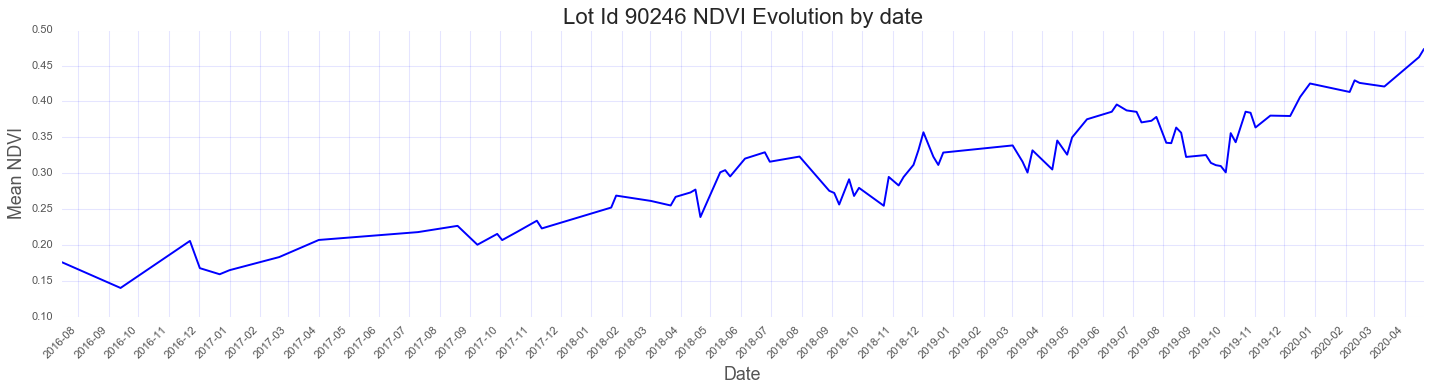

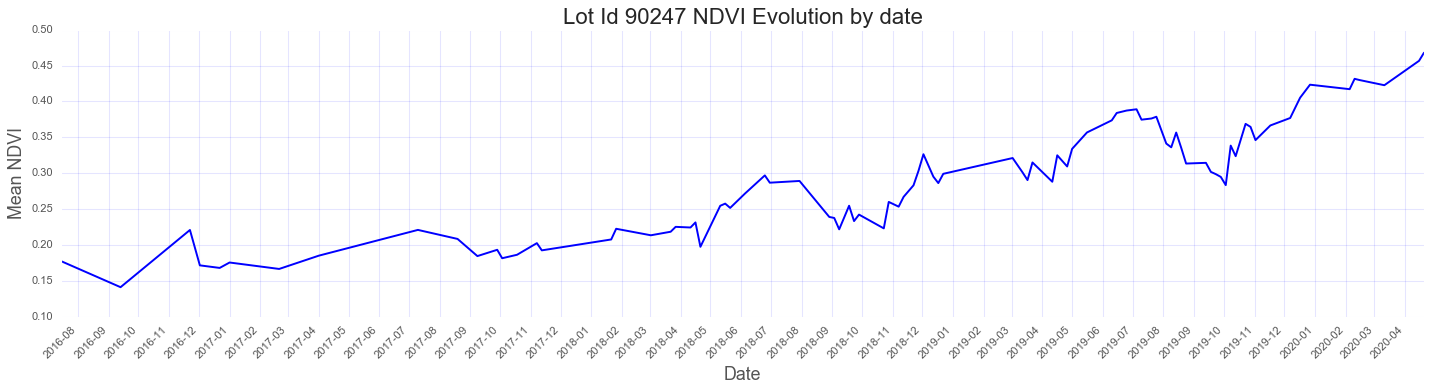

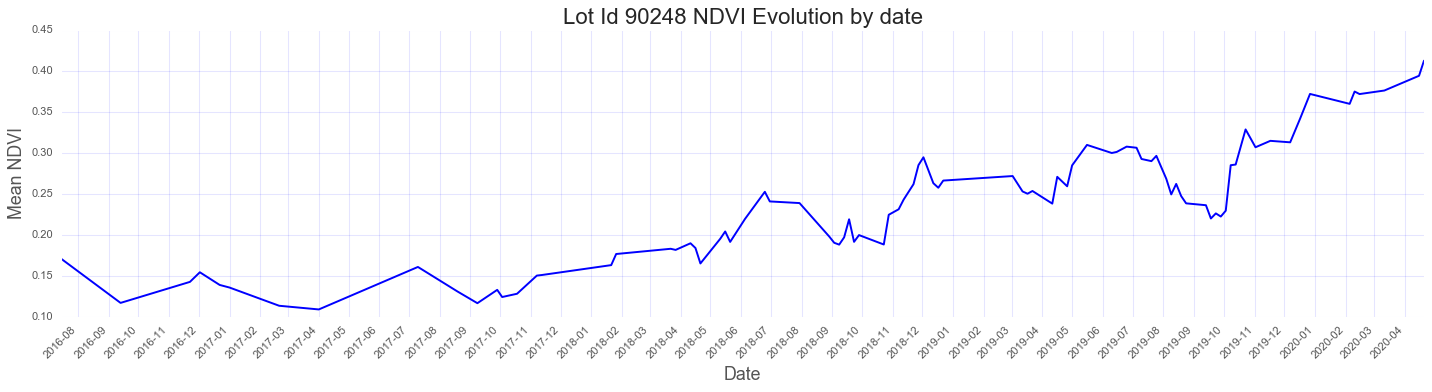

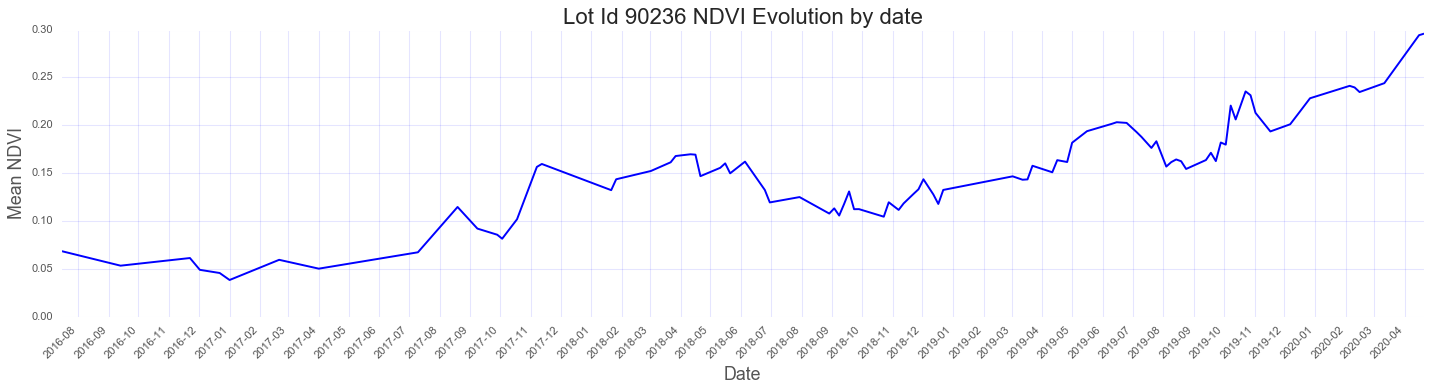

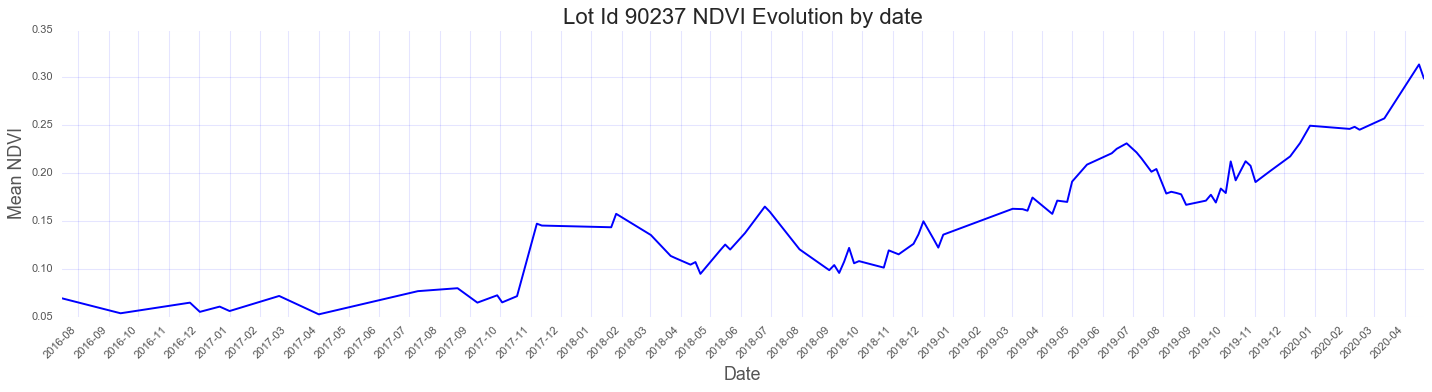

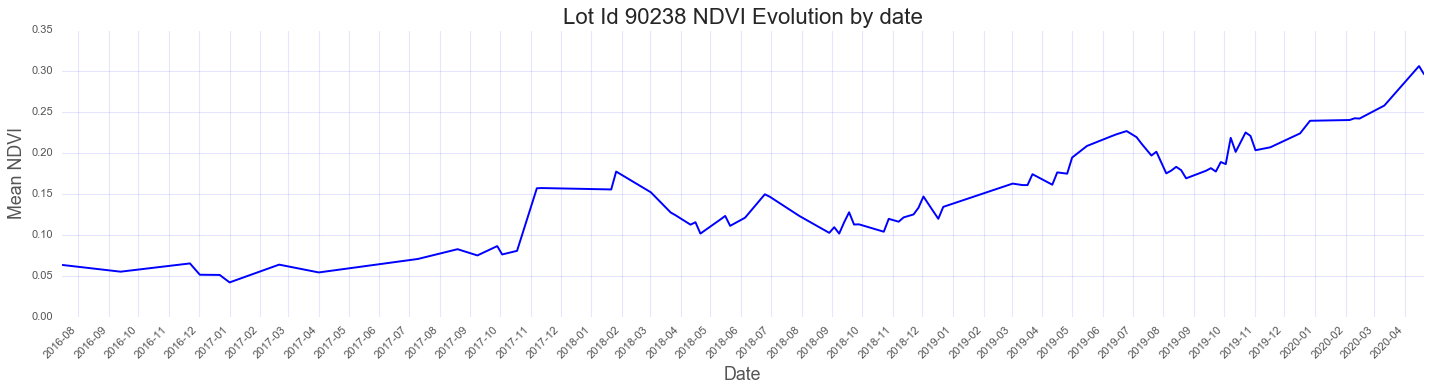

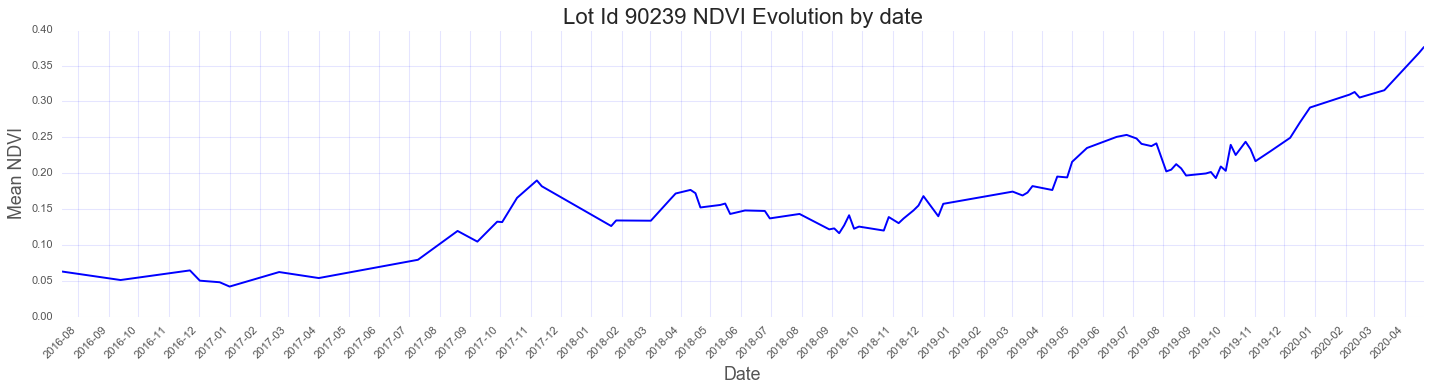

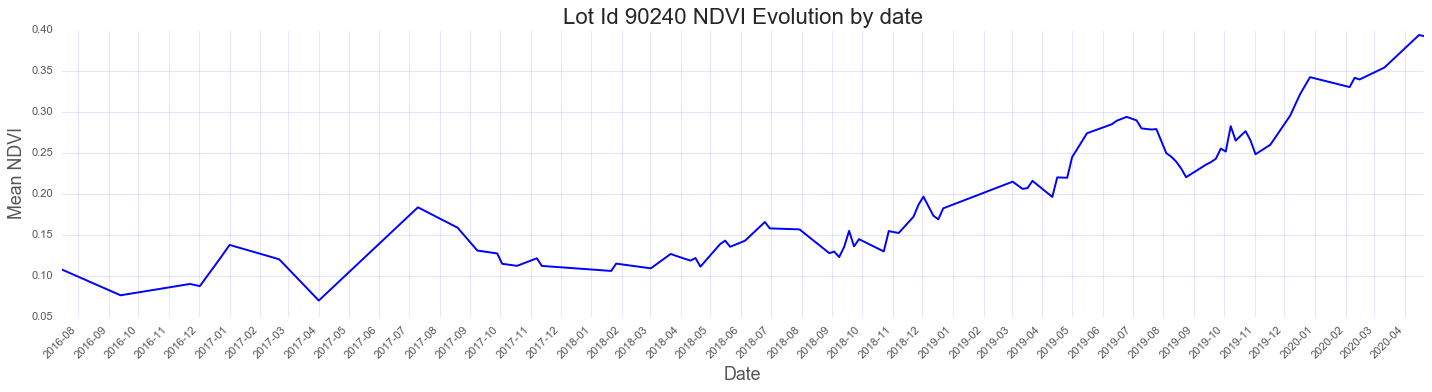

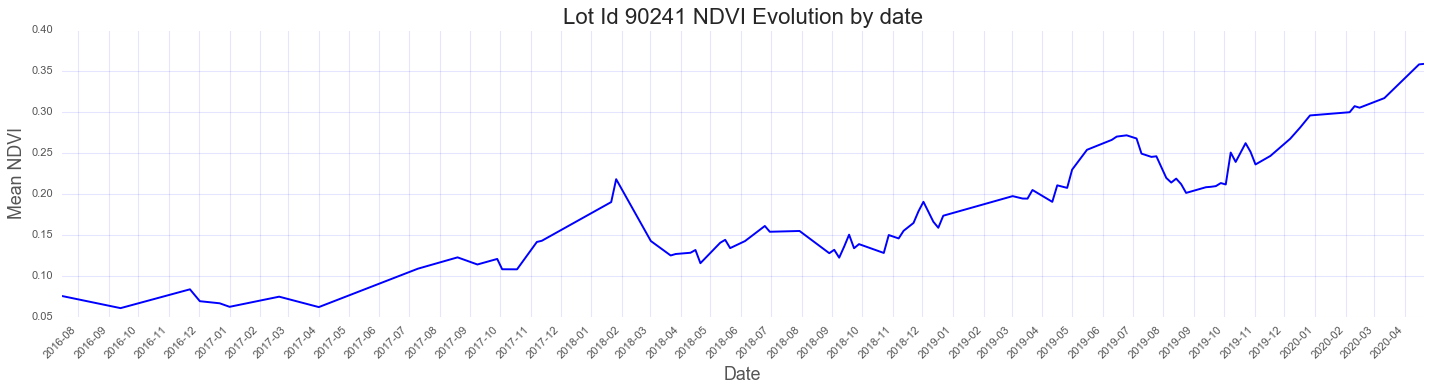

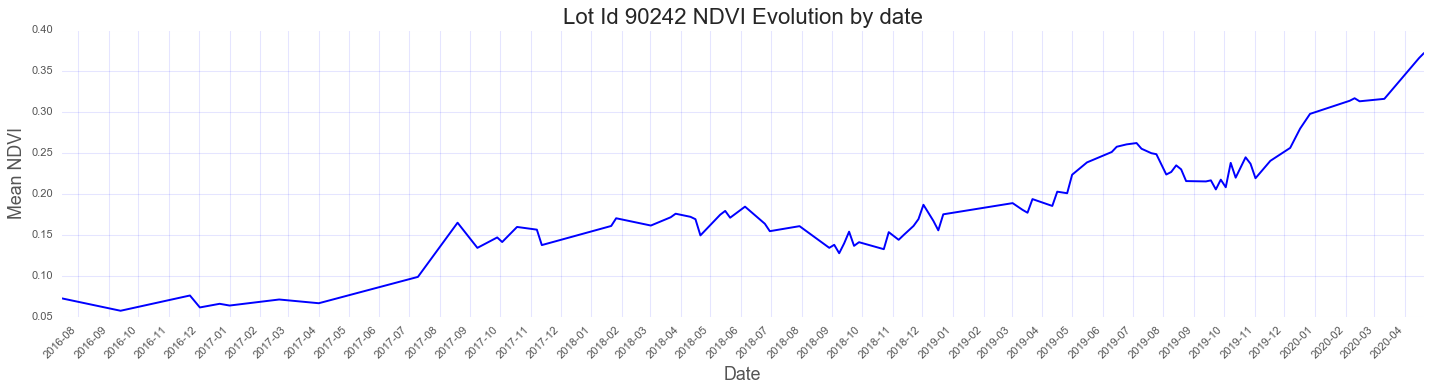

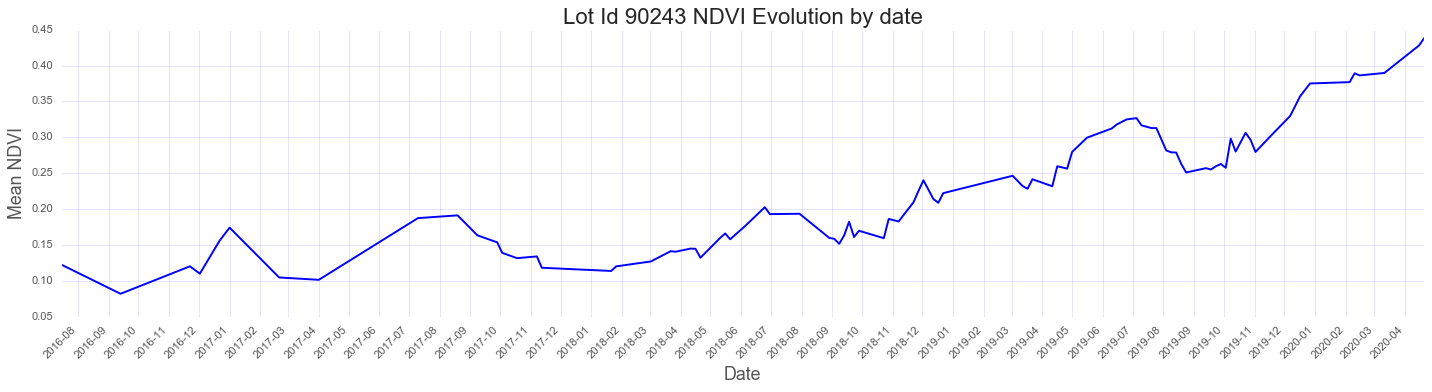

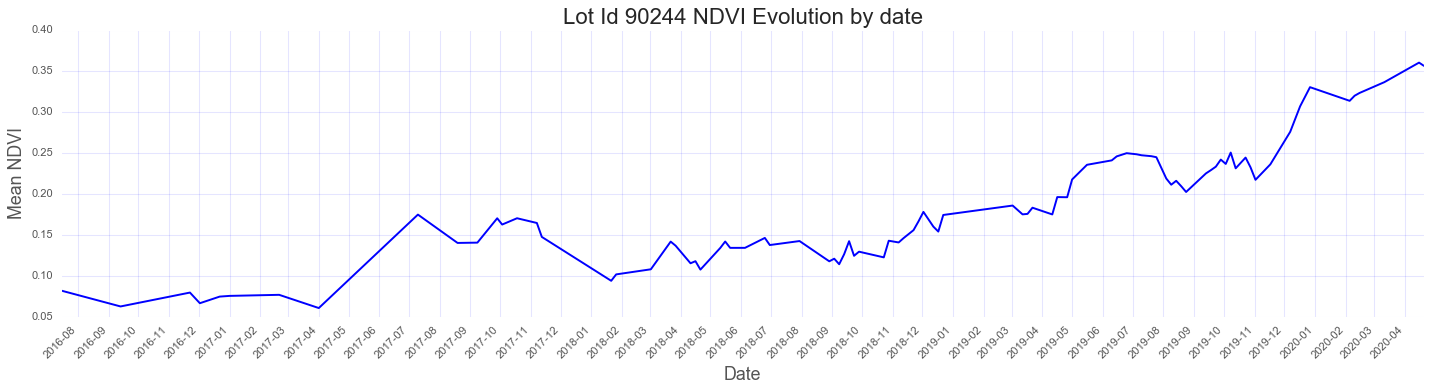

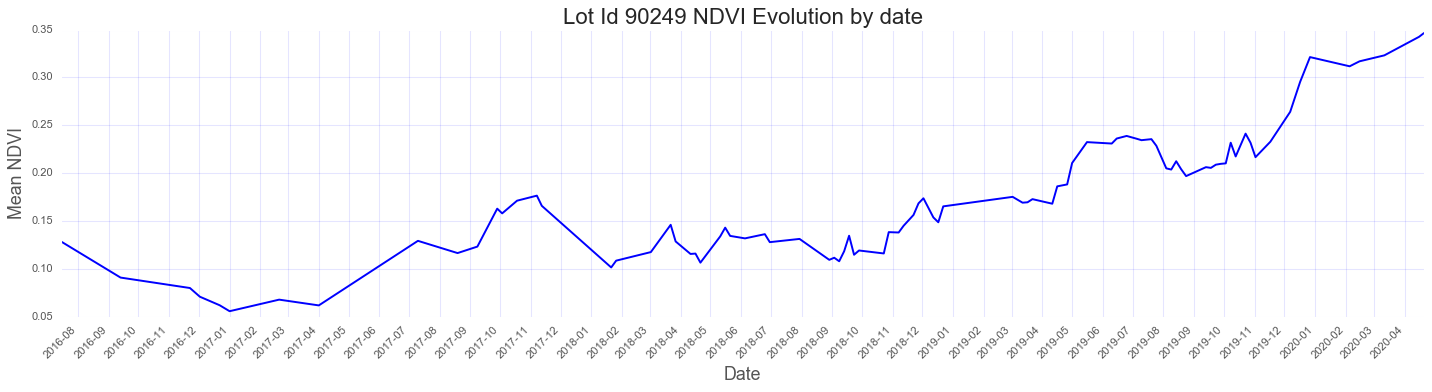

In [290]:
for id in ids:
    sns.lineplot(x = 'date', y = 'mean_ndvi' ,data = data[data['id']==id], color='blue')
    plt.grid(color = 'b', alpha = 0.1)
    plt.title("Lot Id {} NDVI Evolution by date".format(id), fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Mean NDVI', fontsize=16)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
    plt.xticks()
    plt.tight_layout()
    plt.show()

Ahora lo idea es analizar a través del  tiempo cada uno de los lotes. 
Se observa como el primer grupo, que son los lotes cuyo id va de 90234 hacia abajo, cuyo comportamiento es prácticamente identico. Se ve estabilidad hacia valores promedio de NDVI altos, por sobre  0.4 y cuyos peaks a la baja coinciden en las fechas.  Se puede estimar que las fechas en las que coinciden las bajas puede haber sido un factor en el cual se estaba plantando para una nueva temporada o tal vez por una época del año con mayor nubosidad por lo que se vieron afectados los valores.
Por otro lado el mismo primer grupo, entre agosto de 2016 y octubre de 2017 muestra un comportamiento distinto que desde Noviembre de 2018 en adelante. Podría tratarse de un tipo de cultivo distinto en la zona.

Ahora, el segundo grupo también entrega algo interesante. se ve que efectivamente por un periódo de tiempo, no hubo indicios de vegetación ya que hasta Noviembre o Diciembre de 2018 es que recién comienza a subir el NDVI a valores por sobre 0.2. Luego de esa fecha en adelante,se ha visto un crecimiento relativamente constante para todos los lotes de este grupo.

In [294]:
ids_1 = data['id'][data['id']<=90234].unique()
ids_1

array([90214, 90215, 90216, 90217, 90218, 90219, 90221, 90222, 90224,
       90225, 90227, 90228, 90229, 90230, 90231, 90232, 90233, 90234],
      dtype=object)

In [295]:
ids_2 = data['id'][data['id']>90234].unique()
ids_2

array([90250, 90251, 90246, 90247, 90248, 90236, 90237, 90238, 90239,
       90240, 90241, 90242, 90243, 90244, 90249], dtype=object)

In [297]:
#New column with tag to differentiate the groups before mentioned
data['tag'] = np.where(data['id']<=90234, 1, 2)

In [301]:
plt.rcParams['figure.figsize'] = (18.0, 7)

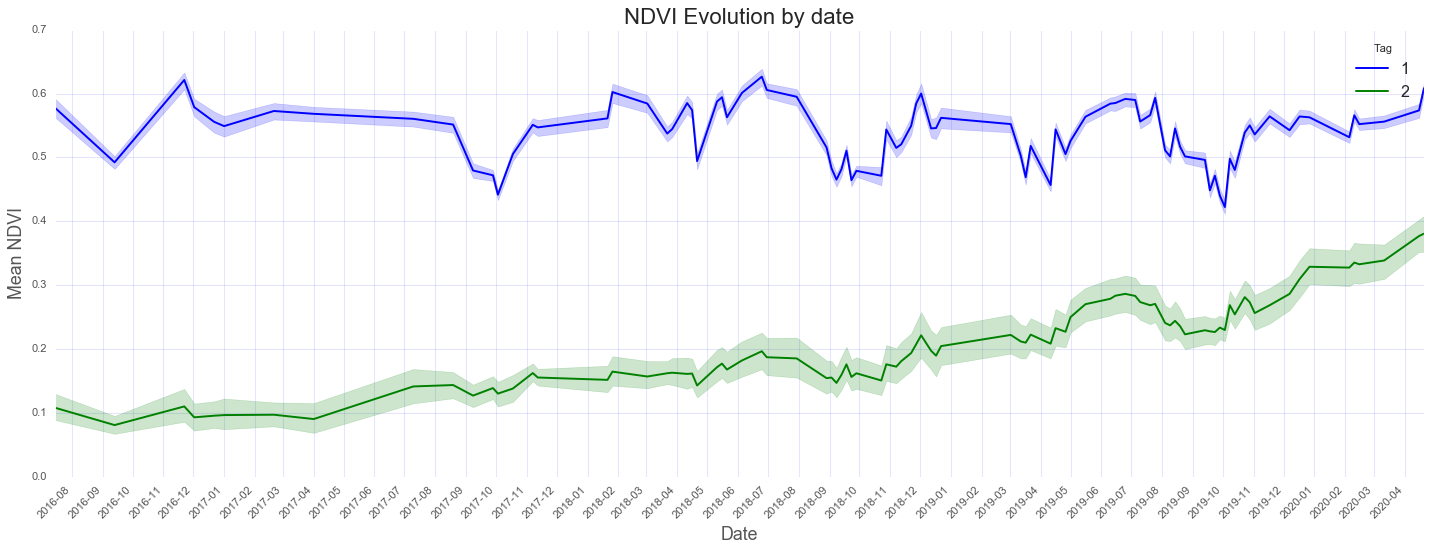

In [322]:
sns.lineplot(x = 'date', y = 'mean_ndvi' ,data = data, hue = data['tag'], palette = ['b','g'])
plt.grid(color = 'b', alpha = 0.1)
plt.title("NDVI Evolution by date", fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean NDVI', fontsize=16)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
plt.legend(title='Tag', labels=['1', '2'],  fontsize = 'x-large')
plt.xticks()
plt.tight_layout()

Con el tag creado para cada uno de los lotes, se muestra la tendencia y lo mencionado anteriormente con respecto al comportamiento de cada uno de los grupos. Igualmente  es posible observar el primer grupo (color azul), tiene menor varabilidad que el segundo, el comportamiento es prácticamente idéntico.
Además se podría inferir que los grupos representan lotes que se encuentran en una misma zona y con un mismo tipo de cultivo.

In [325]:
#columns with year and month
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month
data.head()

,id,date,name,mean_ndvi,tag,year,month
0,90214,2016-07-15,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.514680,1,2016,7
1,90214,2016-09-13,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.450306,1,2016,9
2,90214,2016-11-22,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.565036,1,2016,11
3,90214,2016-12-02,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.520824,1,2016,12
4,90214,2016-12-22,AGRICOLA CHAPI.DON ERNESTO.PAL-1.36,0.486083,1,2016,12


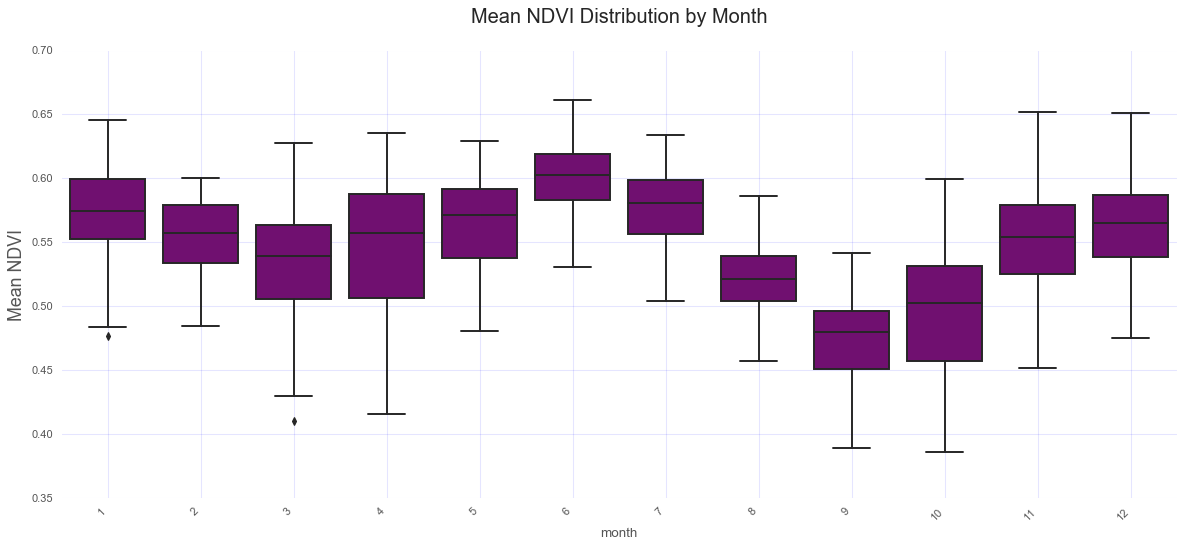

In [329]:
sns.boxplot(y="mean_ndvi",x = "month", data=data[data['tag']== 1], color='purple')
plt.grid(color = 'b', alpha = 0.1)
plt.title('Mean NDVI Distribution by Month\n', fontsize=18)
plt.ylabel('Mean NDVI', fontsize=16)
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")
plt.show()

Por último, se analiza en particular el primer grupo de lotes, ya que su comportamiento pareciera tener cierta estacionalidad. Es por esto que se muestra por mes el comportamiento y se concluye que hay meses en los cuales debe haber una mayor abundancia respecto de otros.